In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions
def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = np.float(location[2])
    lat = np.float(location[3])
    elev = np.float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(np.float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def cal_xf_tf(usm, vsm, vt, H, perturb_vt=False, sigma=0.1):
    """Computes final horizontal position and residence time (relative to starting position) of a raindrop
       falling through a horizontally homogeneous layer H with terminal velocity vt and 
       storm releative mean wind given by (usm, vsm)."""
    
    if perturb_vt:
        rng = np.random.default_rng()
        vt_perts = sigma * rng.standard_normal(vt.size)
        vt = vt + vt_perts
    
    tf = H / vt
    xf = tf * usm
    yf = tf * vsm
    
    return xf, yf, tf


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked'):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between successive times
    # and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv, base_field_name='reflectivity_masked', method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    base_field = radar_ds[base_field_name]
    oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
    
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from the "base"
    # field (by default, reflectivity)
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        new_time = new_time + tintv
        
        pos1 = (y - i / tintv_obs * oflow_field[1], x - i / tintv_obs * oflow_field[0])
        pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                x + (tintv_obs - i) / tintv_obs * oflow_field[0])
        
        field_interp_list = []
        for field_name, field_da in radar_ds.items():
            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)
       
            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)
        
        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list


def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list


def plot_animation(xplt, yplt, field, clevels, cbarlabel=None, cbarintv=None, cmap='pyart_HomeyerRainbow', 
                   norm=None, PIPS_loc=None, ax=None, ptype='pcolor', axestickintv=10000., axeslimits=None):
    
    if norm is None:
        norm = cm.colors.Normalize(vmin=clevels[0], vmax=clevels[-1])
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.get_figure()
    ims = []
    for i, var in enumerate(var_da):
        plotdata = []
        time = np.datetime_as_string(var.coords['time'].values, unit='m')  # Ugly, but whatever
        
        title = ax.text(0.5,1.05,"Time: {}".format(time), 
                        size=plt.rcParams["axes.titlesize"],
                        ha="center", transform=ax.transAxes)
        plotdata.append(title)
        
        if ptype == 'pcolor':
            ci = ax.pcolormesh(xplt, yplt, var.squeeze(), vmin=clevels[0], vmax=clevels[-1], cmap=cmap, 
                                     norm=norm)
            plotdata.append(ci)
        else:
            ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                             cmap=cmap, norm=norm)
            plotdata.extend(ci.collections)
            
        if PIPS_loc is not None:
            # Plot PIPS location
            ax.plot([PIPS_loc[0]], [PIPS_loc[1]], 'k*')
        if i == 0.:
            if cbarintv is None:
                cbarintv = clevels[1] - clevels[0]
            cbarlevels = ticker.MultipleLocator(base=cbarintv)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
            if cbarlabel is not None:
                cax.set_ylabel(cbarlabel)
            formatter = ticker.FuncFormatter(mtokm)
            ax.xaxis.set_major_formatter(formatter)
            ax.yaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
            ax.set_xlabel('km')
            ax.set_ylabel('km')
            if axeslimits is None:
                xmin = xplt[0]
                xmax = xplt[-1]
                ymin = yplt[0]
                ymax = yplt[-1]
            else:
                xmin, xmax, ymin, ymax = axeslimits
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_aspect('equal')
            
        ims.append(plotdata)
    
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    plt.close()
    return ani

In [3]:
# Read in the file containing the original gridded radar at the top of the sorting layer
radar_name = 'KGWX'
radar_type= 'NEXRAD'
date = '0325'
radar_start_datetimestamp = '20170325170500'
radar_end_datetimestamp = '20170325183559'
height = 1000.

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/IOP_1A/'
gridded_radar_dir = os.path.join(radar_basedir, 'gridded_new')
# plot_dir = os.path.join(gridded_radar_dir, 'plots')
plot_dir = '/Users/terrell8/Dropbox/Presentations/IOP_1A'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

radar_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

# Read in original gridded radar at top of sorting layer
gridded_radar_interp_filename = '{}_{}_{}_z{:d}_gridded_interp.nc'.format(radar_name, radar_start_timestamp,
                                                                          radar_end_timestamp, int(height))
gridded_radar_interp_filepath = os.path.join(gridded_radar_dir, gridded_radar_interp_filename)
gridded_radar_interp_ds = xr.open_dataset(gridded_radar_interp_filepath)

In [4]:
# Read in the "sorted" gridded radar at bottom of sorting layer
radar_sorted_start_datetimestamp = '20170325170500'
radar_sorted_end_datetimestamp = '20170325183559'
height = 1000.

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_sorted_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_sorted_end_datetimestamp, '%Y%m%d%H%M%S')

radar_sorted_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_sorted_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

gridded_radar_sorted_filename = '{}_{}_{}_d{:d}_gridded_sorted.nc'.format(radar_name, 
                                                                          radar_sorted_start_timestamp,
                                                                          radar_sorted_end_timestamp, 
                                                                          int(height))
gridded_radar_sorted_filepath = os.path.join(gridded_radar_dir, gridded_radar_sorted_filename)
gridded_radar_sorted_ds = xr.open_dataset(gridded_radar_sorted_filepath)

In [5]:
# Extract x and y coordinates from sorted grid file. These represent the *left* edges of the grid cells,
# not the centers, and are therefore missing the final *right* edge. This is because of the way I constructed
# the coordinates. I really should have used the grid centers. Anyway, add the final edge here and then
# calculate the grid centers
# TODO: go back and fix this in the calc_precip_trajectories... notebook

xedges = gridded_radar_sorted_ds.coords['x'].values
dx = xedges[1] - xedges[0]
xedges = np.append(xedges, xedges[-1] + dx)

yedges = gridded_radar_sorted_ds.coords['y'].values
dy = yedges[1] - yedges[0]
yedges = np.append(yedges, yedges[-1] + dy)

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

In [6]:
# Read in PIPS data (just to get lat/lon for now)
deployment = 'IOP1A_D1_2017'
PIPS_list = ['PIPS1A', 'PIPS1B', 'PIPS2B']
PIPS_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15'

PIPS_ds_list = []
PIPS_locs = []

for PIPS in PIPS_list:
    PIPS_filename = 'parsivel_combined_{}_{}_60s.nc'.format(deployment, PIPS)
    PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
    PIPS_ds = xr.load_dataset(PIPS_filepath)
    PIPS_ds_list.append(PIPS_ds)
    PIPS_loc = eval(PIPS_ds.location)
    PIPS_locs.append(PIPS_loc)

In [7]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})

radar_at_PIPS_list = []
PIPS_xy_list = []

for PIPS_loc in PIPS_locs:
    PIPS_lat = PIPS_loc[0]
    PIPS_lon = PIPS_loc[1]
    radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
    print(PIPS_lat, PIPS_lon)
    PIPS_x = radar_at_PIPS_da['x'].values.item()
    PIPS_y = radar_at_PIPS_da['y'].values.item()
    PIPS_xy = (PIPS_x, PIPS_y)
    PIPS_xy_list.append(PIPS_xy)
    print(PIPS_x, PIPS_y)
    radar_at_PIPS_list.append(radar_at_PIPS_da)

34.52066666666667 -87.29449642611682
96728.93000427012 70166.01339832682
34.55866666666668 -87.33733333333335
92724.06195679221 74392.05024919243
34.57283333333333 -87.3925
87566.5175618068 75967.54664630194


In [11]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
# EDIT: don't need storm motion because it is implicitly handled in time-dependent trajectory model
# ustorm = 12.51
# vstorm = 12.95

# EDIT: setting ustorm, vstorm to 0 to force ground-relative flow
ustorm = 0.
vstorm = 0.

sounding_dir = '/Users/terrell8/Dropbox/0325_sounding/sounding_zip/'
sounding_filename = 'Courtland_1759.txt'
# sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
# sounding_filename = 'Hollywood_201704301954.cls'
sounding_path = os.path.join(sounding_dir, sounding_filename)
sounding_metadata, sounding_df = readESC(sounding_path)

Cour
["087 20.94'W", " 34 39.29'N", ' -87.349', ' 34.655', ' 177.0']


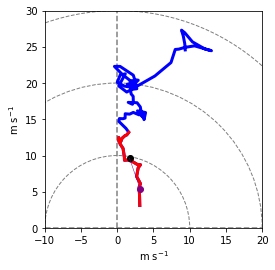

In [12]:
from metpy.plots import SkewT, Hodograph

# ustorm, vstorm = (4.121136597951332, 6.968096312979091) # From mean of pysteps u and v field (04/30)
# ustorm, vstorm = (4.893569553782078, 2.6387864245583765) # 03/27
ustorm, vstorm = (3.164247877224066, 5.370989998643443) #03/25

hodo_units='m/s'

u = sounding_df['u']
v = sounding_df['v']
z = sounding_df['height'] - sounding_metadata['selev']

u1km = u.loc[z <= 1000.]
v1km = v.loc[z <= 1000.]

u1kmavg = u1km.mean()
v1kmavg = v1km.mean()

ug1km = u.loc[~(z <= 1000.)]
vg1km = v.loc[~(z <= 1000.)]

hodo = Hodograph(component_range=40)
hodo.add_grid(increment=10)
if(hodo_units == 'm/s'):
    hodo.plot(u, v, color='b')
    hodo.plot(u1km, v1km, color='r')
    hodo.plot(u1kmavg, v1kmavg, color='k', marker='o')
    hodo.plot(ustorm, vstorm, color='purple', marker='o')
    hodo.plot([ustorm, u1kmavg], [vstorm, v1kmavg], color='purple', linewidth=0.5)
    hodo.ax.set_xlim(-10., 20.)
    hodo.ax.set_ylim(0., 30.)
    hodo.ax.set_xlabel(r'm s$^{-1}$')
    hodo.ax.set_ylabel(r'm s$^{-1}$')
else:
    hodo.plot(u,v)
    hodo.ax.set_xlabel('kts')
    hodo.ax.set_ylabel('kts')
#hodo.ax.set_xlim(-10.,40.)

plot_filename = '{}_hodo.png'.format(sounding_filename[:-4]) 
plot_filepath = os.path.join(plot_dir, plot_filename)
plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [ ]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})
radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
PIPS_x = radar_at_PIPS_da['x'].values.item()
PIPS_y = radar_at_PIPS_da['y'].values.item()
print(radar_at_PIPS_da)

In [ ]:
# Set up start and end time objects and strings for animations
anim_start = '2017-04-30T20:00'
anim_end = '2017-04-30T21:30'

anim_start_datetime = datetime.strptime(anim_start, '%Y-%m-%dT%H:%M')
anim_end_datetime = datetime.strptime(anim_end, '%Y-%m-%dT%H:%M')

anim_start_out = anim_start_datetime.strftime('%Y%m%d%H%M')
anim_end_out = anim_end_datetime.strftime('%Y%m%d%H%M')

In [ ]:
# Plot reflectivity for time-interpolated grid
var_da = gridded_radar_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))
# print(var_da.coords['time'].values)
xplt = var_da.coords['x']
yplt = var_da.coords['y']

clevels = np.arange(0., 61., 1.)
cbarintv = 10.
norm = cm.colors.Normalize(vmin=0., vmax=60.)

ani = plot_animation(xplt, yplt, var_da, clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                     cmap='pyart_HomeyerRainbow', norm=norm, PIPS_loc=[PIPS_x, PIPS_y], ax=None, 
                     ptype='contourf', axestickintv=50000., axeslimits=None)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_grid_z{:d}_big_dBZ.mp4'.format(radar_name, anim_start_out, anim_end_out, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ND animation for a given diameter bin
D_to_plot = 1.  # Diameter of raindrop to plot. Will select the nearest central value of the Parsivel bin

var_da = gridded_radar_sorted_ds['ND'].sel(diameter=D_to_plot, method='nearest')
var_da = var_da.sel(time=slice(anim_start, anim_end))

clevels = np.logspace(-1., 4., num=100)
norm = cm.colors.LogNorm(vmin=1., vmax=10000.)

# Put call to plot_animation here...

In [ ]:
# Plot reflectivity at bottom of sorting layer

var_da = gridded_radar_sorted_ds['REF']
clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)
cbarintv = 10.

ani = plot_animation(xctr, yctr, var_da, clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                     cmap='pyart_HomeyerRainbow', norm=norm, PIPS_loc=[PIPS_x, PIPS_y], ax=None, 
                     ptype='contourf', axestickintv=10000., axeslimits=None)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_d{:d}_grid_bottom_dBZ.mp4'.format(radar_name, radar_sorted_start_timestamp, 
                                                     radar_sorted_end_timestamp, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot reflectivity at top of sorting layer (zoomed in to same limits as the animation at the bottom of the
# sorting layer)

var_da = gridded_radar_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))
xplt = gridded_radar_interp_ds.coords["x"]
yplt = gridded_radar_interp_ds.coords["y"]

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)
cbarintv = 10.

ani = plot_animation(xplt, yplt, var_da, clevels, cbarintv=cbarintv, cbarlabel='dBZ', 
                     cmap='pyart_HomeyerRainbow', norm=norm, PIPS_loc=[PIPS_x, PIPS_y], ax=None, 
                     ptype='contourf', axestickintv=50000., axeslimits=[xedges[0], xedges[-1], 
                                                                        yedges[0], yedges[-1]])

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_grid_z{:d}_dBZ.mp4'.format(radar_name, anim_start_out, anim_end_out, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ZDR at bottom of sorting layer

var_da = gridded_radar_sorted_ds['ZDR']
clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)
cbarintv = 1.

ani = plot_animation(xctr, yctr, var_da, clevels, cbarintv=cbarintv, cbarlabel='ZDR (dB)', 
                     cmap='plasma', norm=norm, PIPS_loc=[PIPS_x, PIPS_y], ax=None, 
                     ptype='contourf', axestickintv=50000., axeslimits=None)

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_d{:d}_grid_bottom_ZDR.mp4'.format(radar_name, anim_start_out, anim_end_out, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Plot ZDR at top of sorting layer (zoomed in to same limits as the animation at the bottom of the
# sorting layer)

var_da = gridded_radar_interp_ds['differential_reflectivity_masked'].sel(time=slice(anim_start, anim_end))
xplt = gridded_radar_interp_ds.coords["x"]
yplt = gridded_radar_interp_ds.coords["y"]

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)
cbarintv = 1.

ani = plot_animation(xplt, yplt, var_da, clevels, cbarintv=cbarintv, cbarlabel='ZDR (dB)', 
                     cmap='plasma', norm=norm, PIPS_loc=[PIPS_x, PIPS_y], ax=None, 
                     ptype='contourf', axestickintv=50000., axeslimits=[xedges[0], xedges[-1], 
                                                                        yedges[0], yedges[-1]])

HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = '{}_{}_{}_grid_z{:d}_ZDR.mp4'.format(radar_name, anim_start_out, anim_end_out, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
# Compute polarimetric fields from PIPS DSDs
dD = PIPS_ds['max_diameter'] - PIPS_ds['min_diameter']
dualpol_dict_PIPS = dualpol.calpolrain_bulk_xr(10.7, 
                                               '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                               PIPS_ds['ND_qc'], dD, diameter_bin_name='diameter_bin')

In [ ]:
# Interpolate Z and ZDR from sorted grid to PIPS location
ZH_sorted_PIPS_da = gridded_radar_sorted_ds['REF'].interp(x=PIPS_x, y=PIPS_y)
ZDR_sorted_PIPS_da = gridded_radar_sorted_ds['ZDR'].interp(x=PIPS_x, y=PIPS_y)
ZH_PIPS = dualpol_dict_PIPS['REF']
ZDR_PIPS = dualpol_dict_PIPS['ZDR']
ZH_radar_at_PIPS = PIPS_ds['KHTX_at_PIPS'].sel(fields_KHTX='REF_filtered')
ZDR_radar_at_PIPS = PIPS_ds['KHTX_at_PIPS'].sel(fields_KHTX='ZDR_filtered')
ZH_gridded_radar_at_PIPS = radar_at_PIPS_da['reflectivity_masked']
ZDR_gridded_radar_at_PIPS = radar_at_PIPS_da['differential_reflectivity_masked']

In [ ]:
plot_start = '2017-04-30T20:30'
plot_end = '2017-04-30T21:30'

plot_start_datetime = datetime.strptime(plot_start, '%Y-%m-%dT%H:%M')
plot_end_datetime = datetime.strptime(plot_end, '%Y-%m-%dT%H:%M')

plot_start_out = plot_start_datetime.strftime('%Y%m%d%H%M')
plot_end_out = plot_end_datetime.strftime('%Y%m%d%H%M')

In [ ]:
# Plot reflectivity at PIPS location, comparing PIPS observation, gridded radar at 1 km, and sorting-model
# results at the surface

fig, ax = plt.subplots(figsize=(10, 10))
ZH_PIPS.plot.line(xlim=(plot_start, plot_end), color='k', label='PIPS observed surface DSD')
ZH_gridded_radar_at_PIPS.plot.line(xlim=(plot_start, plot_end), color='r', label='Radar at 1km AGL')
ZH_sorted_PIPS_da.plot.line(xlim=(plot_start, plot_end), color='b', label='Sorting-model surface DSD')
ax.legend()
ax.set_title('Reflectivity at PIPS')
ax.set_ylabel('dBZ')
ax.set_ylim(0.0, 60.0)

plot_filename = 'Z_at_PIPS_{}_{}.png'.format(plot_start_out, plot_end_out)
plot_path = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Plot differential reflectivity at PIPS location, comparing PIPS observation, gridded radar at 1 km, and 
# sorting-model results at the surface

fig, ax = plt.subplots(figsize=(10, 10))
ZDR_PIPS.plot.line(xlim=(plot_start, plot_end), color='k', label='PIPS observed surface DSD')
ZDR_gridded_radar_at_PIPS.plot.line(xlim=(plot_start, plot_end), color='r', label='Radar at 1km AGL')
ZDR_sorted_PIPS_da.plot.line(xlim=(plot_start, plot_end), color='b', label='Sorting-model surface DSD')
ax.legend()
ax.set_title('Differential Reflectivity at PIPS')
ax.set_ylabel('dB')
ax.set_ylim(0.0, 4.0)

plot_filename = 'ZDR_at_PIPS_{}_{}.png'.format(plot_start_out, plot_end_out)
plot_path = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Plot ZDR at bottom of sorting layer for a single time

gridded_radar_sorted_ds_2 = gridded_radar_sorted_ds.swap_dims({'time': 'time_seconds'})

var_da = gridded_radar_sorted_ds_2['ZDR'].sel(time_seconds=120.)
clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)
cbarintv = 1.

xplt = gridded_radar_sorted_ds_2.coords["x"]
yplt = gridded_radar_sorted_ds_2.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)

fig, ax = plt.subplots(figsize=(10,10))
ci = ax.contourf(xplt, yplt, var_da.squeeze(), levels=clevels, cmap='plasma', norm=norm)

cbarintv = 1.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dB')

ax.set_xlim(-26000., -16000.)
ax.set_ylim(-40000., -30000.)
formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('km')
ax.set_ylabel('km')
# ax.legend()
ax.set_aspect('equal')

plot_filename = 'ZDR_bottom_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [ ]:
print(gridded_radar_sorted_ds['time_seconds'])
print(gridded_radar_sorted_ds['time'])